In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import os
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm.notebook import tqdm
import json
import ast
import math
import re
import pandas as pd
from currency_converter import CurrencyConverter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.3/591.3 kB 4.6 MB/s eta 0:00:00


In [ ]:
DATAPATH = './Data'
n_pages = 40
sampleData = pd.DataFrame()  # Initialize an empty DataFrame

for i in range(n_pages):
    file_path = os.path.join(DATAPATH, f'{i}.csv')
    if os.path.exists(file_path):  # Check if the file exists
        new_data = pd.read_csv(file_path)
        sampleData = pd.concat([sampleData, new_data], ignore_index=True)
    else:
        print(f"File not found: {file_path}")

In [ ]:
extractedDf = sampleData[["required_age",
                          "controller_support",
                          "dlc",
                          "supported_languages",
                          "pc_requirements",
                          "developers",
                          "platforms",
                          "release_date",
                          "price_overview",
                          "categories",
                          "genres",
                          "recommendations"]].copy()
extractedDf['controller_support'] = extractedDf['controller_support'].fillna(0)
extractedDf['dlc'] = extractedDf['dlc'].fillna(0)
extractedDf['controller_support'] = extractedDf['controller_support'].fillna(0)
extractedDf = extractedDf.dropna()

In [ ]:
c = CurrencyConverter()
def moneyConversion(fromCurrency, fromAmt, to= "USD"):
    ret = c.convert(fromAmt, fromCurrency, to)
    return ret

attributes = pd.DataFrame(extractedDf.iloc[:, :12])
label = pd.DataFrame(extractedDf.iloc[:, -1])


retDf = pd.DataFrame({'Required_Age':[],
                      'Controller_support':[],
                      'DLC':[],
                      'Supported_languages':[],
                      'PC_Requirements':[],
                      'Developers':[],
                      'Platforms':[],
                      'Release_year':[],
                      'Currency(USD)':[],
                      'Categories(ID)':[],
                      'Genres(ID)':[],
                      'Label(Binary Classification)':[],
                      'Label(Regression)':[]})

for i in tqdm(range(len(extractedDf))):
    attributesElement = attributes.iloc[i]

    if  type(attributesElement['required_age']) == str:
        age = int(re.sub('[^0-9]','', attributesElement['required_age']))
    else:
        age = int(attributesElement['required_age'])

    if attributesElement['controller_support'] == 'full':
        controler = 1
    else:
        controler = 0

    if attributesElement['dlc'] != 0 :
        num_dlc = len(ast.literal_eval(attributesElement['dlc']))
    else:
        num_dlc = 0

    languages = attributesElement['supported_languages'].replace('<strong>*</strong>', '')
    languages = languages.replace('<br>', '')
    languages = len(languages.split(','))

    req = attributesElement['pc_requirements'].lower()
    req = re.sub("\<.*?\>"," ",req)
    req = req.replace('\'', ' ')
    req = req.replace(',', ' ')
    req = req.replace('\\r', ' ')
    req = req.replace('\\n', ' ')
    req = req.replace('\\t', ' ')
    req = req.split(' ')
    req = list(filter(('').__ne__, req))
    proc = None
    if 'processor:' in req:
        procIdx = req.index('processor:')
        proc = ''.join(req[procIdx: procIdx + 6])
        if 'hz' in proc:
            proc = proc[proc.index('hz')-4 :proc.index('hz')+2]
        else:
            proc = None
    elif 'processor' in req:
        procIdx = req.index('processor')
        proc = ''.join(req[procIdx - 2:procIdx+1])
        if 'hz' in proc:
            proc = proc[proc.index('hz')-4 :proc.index('hz')+2]
        else:
            proc = None

    ram = None
    if 'memory:' in req and 'ram' in req:
        ramIdx = req.index('ram')
        ram = ''.join(req[ramIdx: ramIdx + 5])
        if 'mb' in ram:
            ram = ''.join(ram[ram.index('mb') - 3:ram.index('mb') + 2])
        elif 'gb' in ram:
            ram = ''.join(ram[ram.index('gb') - 3:ram.index('gb') + 2])
        else:
            ram = None
    elif 'ram' in req:
        ramIdx = req.index('ram')
        ram = ''.join(req[ramIdx: ramIdx + 5])
        if 'mb' in ram:
            ram = ''.join(ram[ram.index('mb') - 3:ram.index('mb') + 2])
        elif 'gb' in ram:
            ram = ''.join(ram[ram.index('gb') - 3:ram.index('gb') + 2])
        else:
            ram = None
    if ram:
        ram = re.findall('[0-9]+.b', ram)
        ram = ram[0] if len(ram)>0 else None

    requirements = [proc, ram]

    developers = attributesElement['developers'][1:-1]

    platform = ast.literal_eval(attributesElement['platforms'])
    num_plat = 0
    for k, v in platform.items():
        if v == True:
            num_plat += 1
    try:
        # print(ast.literal_eval(attributesElement['release_date'])['date'])
        year = int(ast.literal_eval(attributesElement['release_date'])['date'].split(',')[1])
    except:
        year = None

    priceRaw = attributesElement["price_overview"]
    priceRaw = ast.literal_eval(priceRaw)
    currencyInUS = [round(moneyConversion(priceRaw['currency'], priceRaw['final']/100),2)]

    categories = attributesElement['categories']
    categories = ast.literal_eval(categories)
    categoriesID = np.array(list(i['id'] for i in categories))

    genres = attributesElement['genres']
    genres = ast.literal_eval(genres)
    genresID = np.array(list(int(i['id']) for i in genres))

    labelElement = label.iloc[i]['recommendations']

    labelRaw = ast.literal_eval(labelElement)
    labelRawRegression = labelRaw['total']
    labelRawClassification = 1 if labelRaw['total'] > 560 else 0
    newRow = pd.DataFrame([{'Required_Age':age,
                      'Controller_support':controler,
                      'DLC':num_dlc,
                      'Supported_languages':languages,
                      'PC_Requirements':requirements,
                      'Developers':developers,
                      'Platforms':num_plat,
                      'Release_year':year,
                      'Currency(USD)':currencyInUS,
                      'Categories(ID)':categoriesID,
                      'Genres(ID)':genresID,
                      'Label(Binary Classification)':labelRawClassification,
                      'Label(Regression)':labelRawRegression}])
    retDf = pd.concat([retDf, newRow],
                      ignore_index= True)


  0%|          | 0/13699 [00:00<?, ?it/s]

In [ ]:
store = retDf['Categories(ID)'].apply(max)
max_num = max(store)
tmpStore = retDf['Genres(ID)'].apply(max)
max_num_genres = max(tmpStore)
retDf['RAM']  = 0
retDf['Processor'] = 0

print(max_num, max_num_genres)

for i in range(len(retDf)):
    tmpEnc = [0] * max_num
    element = retDf.iloc[i]['Categories(ID)']
    for j in element:
        tmpEnc[j - 1] = 1
    retDf.at[i, 'Categories(ID)'] = tmpEnc

    tmpEncGenres = [0] * int(max_num_genres)
    elementGenres = retDf.iloc[i]['Genres(ID)']
    for j in elementGenres:
        tmpEncGenres[int(j)-1] = 1
    retDf.at[i, 'Genres(ID)'] = tmpEncGenres

    pc_req = retDf.iloc[i]['PC_Requirements'][:]
    retDf.loc[i, ['Processor']] = pc_req[0]
    retDf.loc[i, ['RAM']] = pc_req[1]

retDf['Developers'].replace(to_replace=retDf['Developers'].unique(),
           value= np.random.permutation(list(range(len(retDf['Developers'].unique())))),
           inplace=True)

retDf['Processor'].replace(to_replace=retDf['Processor'].unique(),
           value= list(range(len(retDf['Processor'].unique()))),
           inplace=True)
retDf['RAM'].replace(to_replace=retDf['RAM'].unique(),
           value= list(range(len(retDf['RAM'].unique()))),
           inplace=True)


retDf['Dev_red'] = retDf['Developers']
dummies = pd.get_dummies(retDf['Dev_red'])
idxes = np.where(dummies.values.sum(axis=0) > 10)[0]

cond = ~retDf['Dev_red'].isin(dummies.columns[idxes])
retDf.loc[cond, 'Dev_red'] = '>_<'
retDf['Dev_red'] = [row.astype(int).tolist() for index, row in dummies.iterrows()]

retDf['Developers'].replace(to_replace=retDf['Developers'].unique(),
        value= list(range(len(retDf['Developers'].unique()))),
        inplace=True)

retDf['Integer_Encoding'] = retDf.apply(lambda row:
    [row['Required_Age']] +
    [row['Controller_support']] +
    [row['DLC']] +
    [row['Supported_languages']] +
    [row['Processor']] +
    [row['RAM']] +
    [row['Platforms']] +
    [row['Release_year']] +
    row['Currency(USD)'] +
    [row['Developers']] +
    row['Categories(ID)'] +
    row['Genres(ID)'],
    axis=1
)

retDf = retDf[['Required_Age', 'Controller_support', 'DLC', 'Supported_languages', \
               'Processor', 'RAM', 'Developers', 'Platforms', 'Release_year', 'Currency(USD)', \
               'Categories(ID)', 'Genres(ID)', 'Integer_Encoding', 'Label(Binary Classification)', 'Label(Regression)', 'Dev_red']]

retDf = retDf.loc[(retDf['Label(Regression)'] > 600) | (retDf['Label(Regression)'] < 300)][::]
retDf = retDf.dropna()

62 74


In [ ]:
len(retDf['Integer_Encoding'].iloc[0])

146

In [ ]:
labels = retDf['Label(Binary Classification)'].values
features = np.array(list(retDf['Integer_Encoding'].values))
perm_idx = np.random.permutation(len(labels))
idx_train = perm_idx[:int(len(labels)*0.8)]
idx_test = perm_idx[int(len(labels)*0.8):]

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=256,
                             max_depth=32,
                             max_samples=len(idx_train))
clf.fit(features[idx_train], labels[idx_train])
print((clf.predict(features[idx_train]) == labels[idx_train]).sum() / len(idx_train))
print((clf.predict(features[idx_test]) == labels[idx_test]).sum() / len(idx_test))

0.9992079656030777
0.8506787330316742


In [ ]:
from matplotlib import figure

import time
import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

Elapsed time to compute the importances: 0.124 seconds


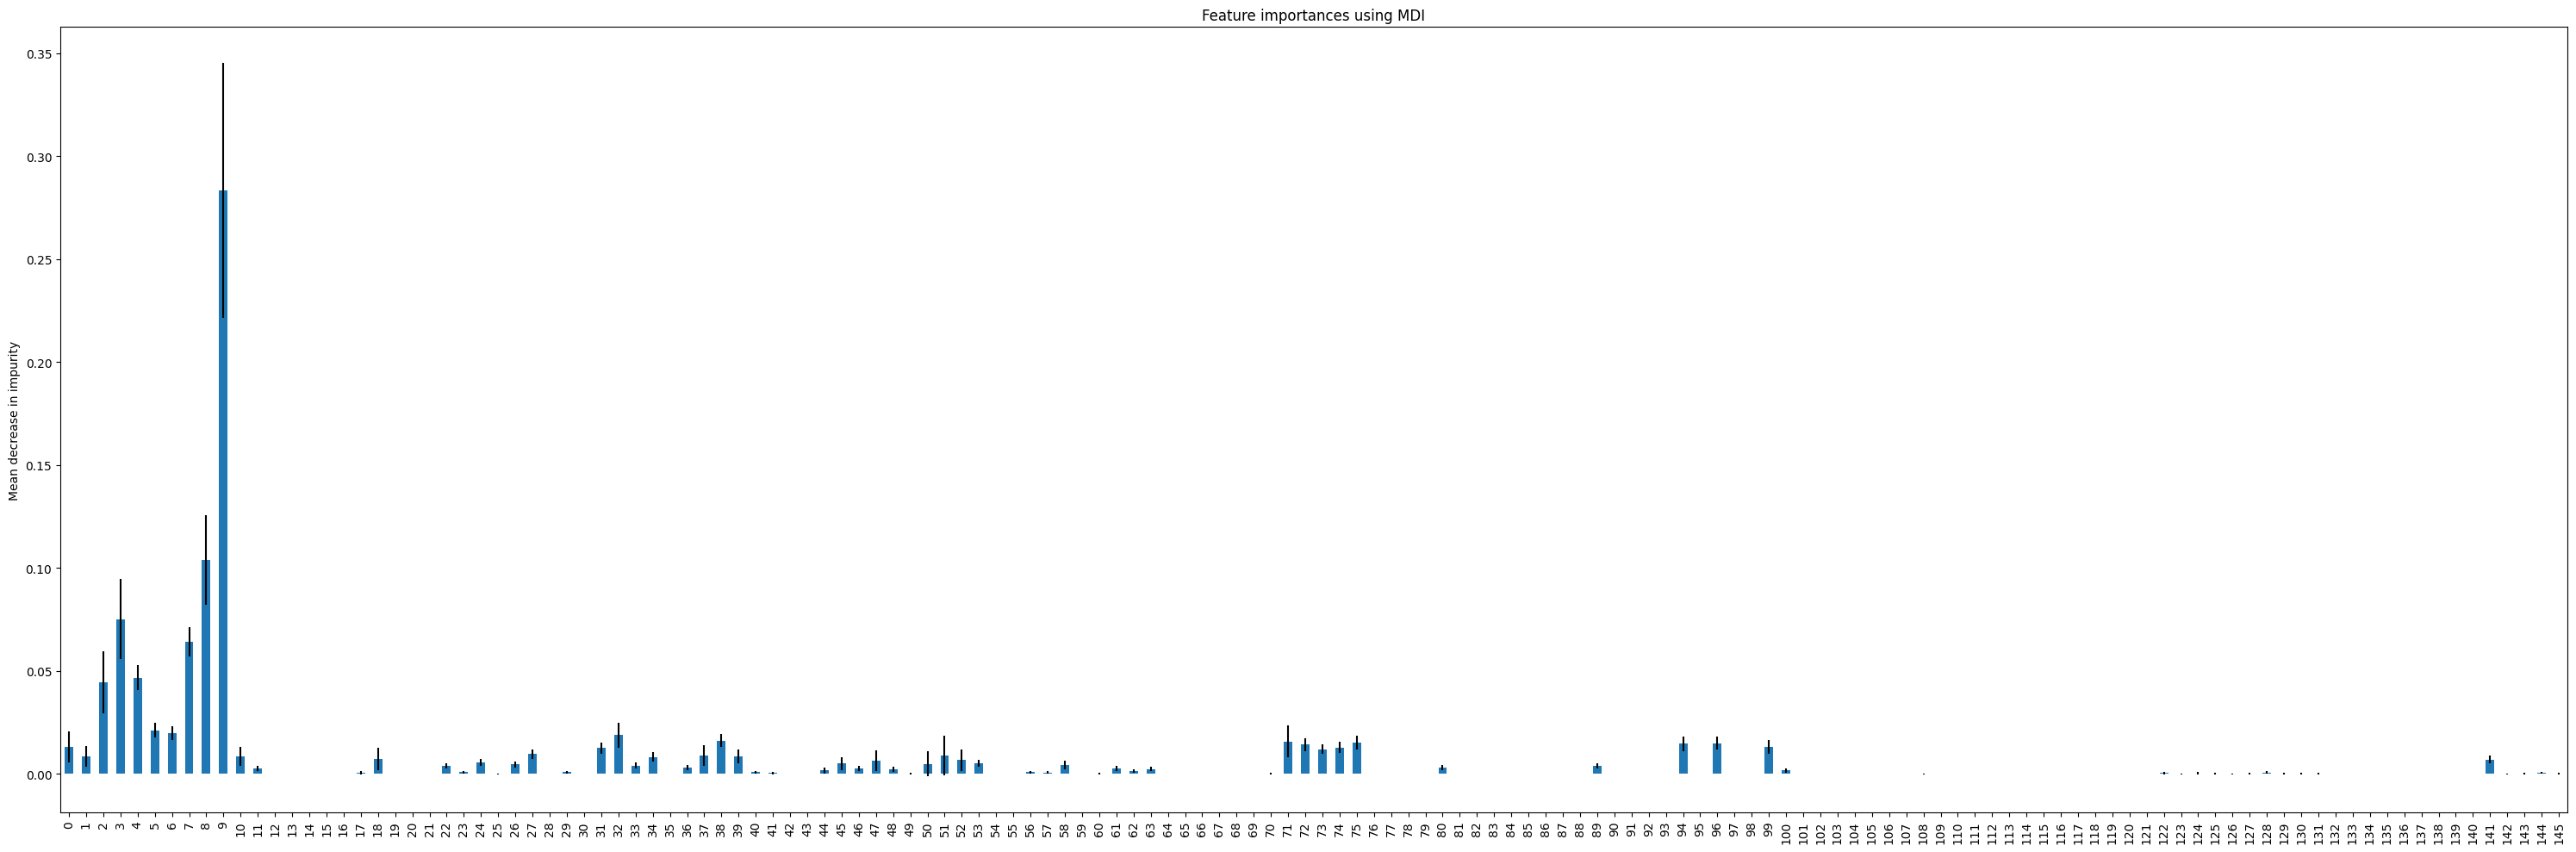

In [ ]:
from matplotlib import figure

import time
import numpy as np

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")


import pandas as pd
import matplotlib.pyplot as plt

forest_importances = pd.Series(importances, index=np.arange(146))

fig, ax = plt.subplots(figsize = (30,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
from collections import Counter

c = Counter(retDf['Developers'].values)

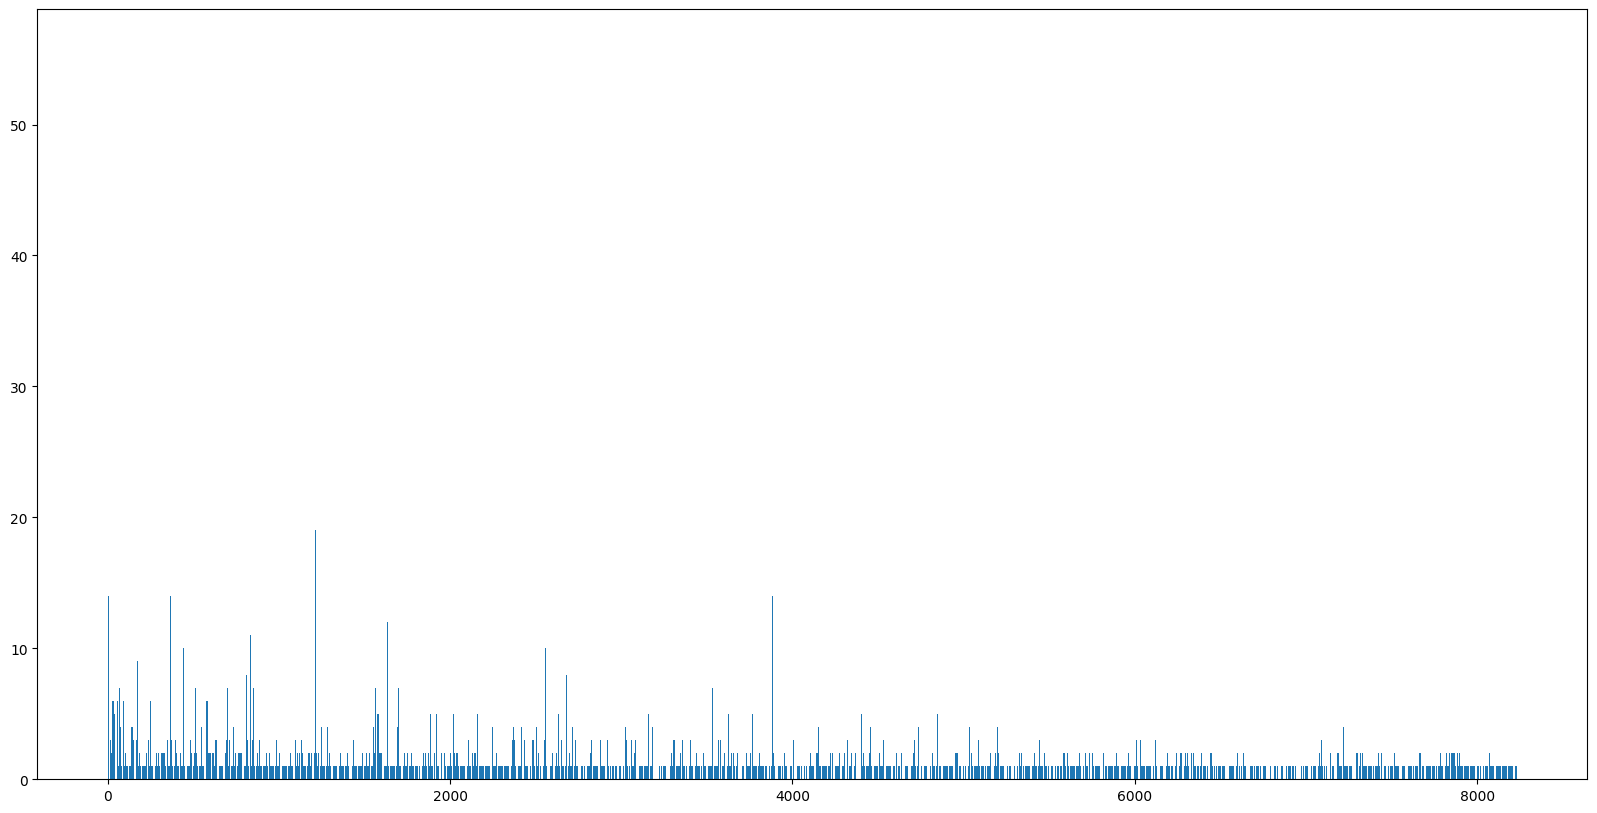

In [ ]:
import matplotlib.pyplot as plt

key = c.keys()
val = c.values()
plt.figure(figsize=(20,10))
plt.bar(key, val)
plt.show()